<a href="https://colab.research.google.com/github/vjardimb/vjardimb/blob/main/LSTM_stock_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
# Raw Package
import numpy as np
import pandas as pd

# Visualization Package
import matplotlib.pyplot as plt

# import preprocessing functions
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

# import keras library
from tensorflow import keras

# import Sequential from the keras models module
from keras.models import Sequential

# import Dense, Dropout, Flatten, Conv2D, MaxPooling2D from the keras layers module
from keras.layers import Dense, Dropout, LSTM

#Data Source
import yfinance as yf

In [53]:
#Interval required 5 minutes
data = yf.download(tickers='aapl', period='10y', interval='1d')

[*********************100%***********************]  1 of 1 completed


In [54]:
#Print data
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-08-15,22.546429,22.642857,22.419643,22.529642,19.319118,257342400
2012-08-16,22.543215,22.741428,22.517857,22.726429,19.487867,254534000
2012-08-17,22.857143,23.149643,22.814644,23.146786,19.848320,442761200
2012-08-20,23.214643,23.755358,23.210714,23.755358,20.370171,613384800
2012-08-21,23.957857,24.102858,23.226070,23.430714,20.091787,812719600


In [55]:
# check if there are missing values for each column
data.isna().any()

Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

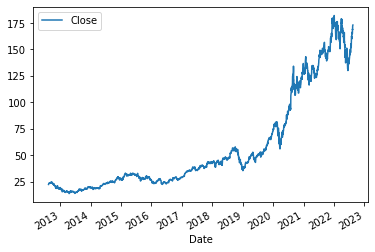

In [56]:
data[['Close']].plot()

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2012-08-15 to 2022-08-15
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2516 non-null   float64
 1   High       2516 non-null   float64
 2   Low        2516 non-null   float64
 3   Close      2516 non-null   float64
 4   Adj Close  2516 non-null   float64
 5   Volume     2516 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 137.6 KB


In [58]:
# create a 7 and 80 moving average
data['7ma'] = data.rolling(7).mean()['Close']
data['60ma'] = data.rolling(60).mean()['Close']

# create a target column (1 if next close is higher than current close, else 0)
data['target'] = (data['Close'].shift(-1) > data['Close']).astype(int)

# drop open, high and low columns
data.drop(['Open', 'High', 'Low', 'Adj Close'], axis=1, inplace=True)

data = data.dropna()

data.head()

,Close,Volume,7ma,60ma,target
Date,,,,,
2012-11-09,19.537857,929913600,20.324592,23.123030,0
2012-11-12,19.386786,515802000,20.050561,23.070649,1
2012-11-13,19.389286,532949200,19.877602,23.015030,0
2012-11-14,19.174286,477170400,19.634030,22.948821,0
2012-11-15,18.772142,789910800,19.342041,22.865768,1


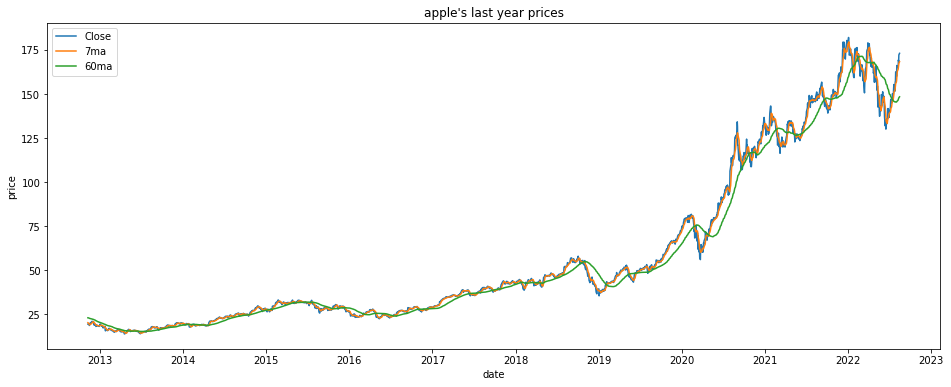

In [59]:
# plot chart with the moving averages
plt.figure(figsize=[16,6])
plt.plot(data['Close'], label='Close')
plt.plot(data['7ma'], label='7ma')
plt.plot(data['60ma'], label='60ma')
plt.legend()
plt.title("apple's last year prices")
plt.xlabel('date')
plt.ylabel('price')
plt.show()

In [60]:
# set features' range to [0,1]
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

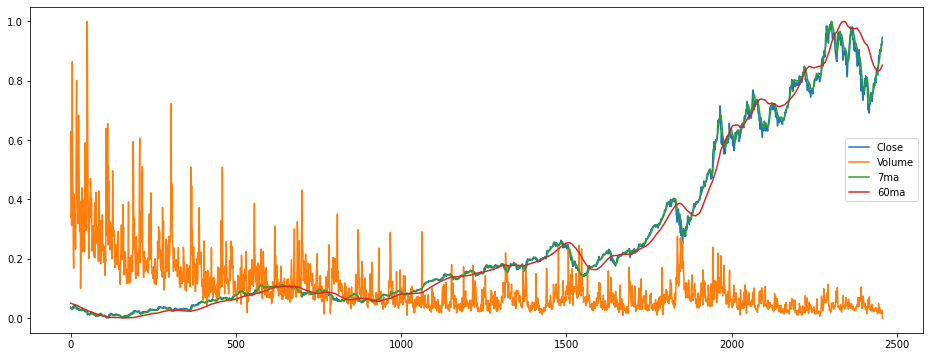

In [61]:
pd.DataFrame(data_scaled[:,:-1], columns=data.columns.to_list()[:-1]).plot(figsize=[16,6])

In [62]:
X, y = [], []

lookback = 60

for i in range(lookback, len(data_scaled)):
  X.append(data_scaled[i-lookback:i,:-1])
  y.append(data_scaled[i,-1])

X, y = np.array(X), np.array(y)

In [63]:
# separete data in training data and test data
train_len = int(len(data)*0.8)

X_train, y_train = X[0:train_len], y[0:train_len]
X_test, y_test = X[train_len:], y[train_len:]

In [64]:
X_test.shape, y_test.shape

((432, 60, 4), (432,))

In [74]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])


In [90]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 60, 50)            11000     
                                                                 
 dropout_9 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_10 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_10 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_11 (Dropout)        (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [80]:
optimizer = keras.optimizers.Adam(lr=0.001)

#compile the RNN
model.compile(optimizer = optimizer, loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [81]:
model.optimizer.learning_rate


<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>

In [82]:
X_train.shape, y_train.shape

((1965, 60, 4), (1965,))

In [83]:
# fit the RNN to the training set
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
62/62 [==============================] - 16s 90ms/step - loss: 0.6929 - accuracy: 0.5064
Epoch 2/100
62/62 [==============================] - 6s 90ms/step - loss: 0.6926 - accuracy: 0.5277
Epoch 3/100
62/62 [==============================] - 6s 97ms/step - loss: 0.6921 - accuracy: 0.5288
Epoch 4/100
62/62 [==============================] - 9s 140ms/step - loss: 0.6920 - accuracy: 0.5303
Epoch 5/100
62/62 [==============================] - 7s 107ms/step - loss: 0.6920 - accuracy: 0.5288
Epoch 6/100
62/62 [==============================] - 9s 146ms/step - loss: 0.6913 - accuracy: 0.5288
Epoch 7/100
62/62 [==============================] - 7s 118ms/step - loss: 0.6916 - accuracy: 0.5293
Epoch 8/100
62/62 [==============================] - 7s 118ms/step - loss: 0.6918 - accuracy: 0.5252
Epoch 9/100
62/62 [==============================] - 7s 112ms/step - loss: 0.6922 - accuracy: 0.5282
Epoch 10/100
62/62 [==============================] - 7s 111ms/step - loss: 0.6917 - accuracy

In [127]:
test_sample = X_train[:1]

def get_precision(model, X_test, y_test, threshold):
  predictions = []

  for i in X_test:
    i = np.reshape(i, (1,i.shape[0], i.shape[1]))
    predicted = model.predict(i)
    predictions.append(int(predicted > threshold))
  results = pd.DataFrame({"predictions": predictions, "targets": y_test})
  results = results[results['predictions']==1]
  return len(results[results['predictions']==results['targets']])/len(results)


In [131]:
# model.predict(X_test[:])
X_test[:1].shape
precision = get_precision(model, X_test, y_test, 0.55
                          )

In [132]:
precision

0.5240384615384616

In [ ]:
precision